# Определение перспективного тарифа для телеком компании

В компании «Мегалайн» — федеральном операторе сотовой связи, клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Содержание

<div style="border:solid black 2px; padding: 10px">    
    
### [Шаг 1. Знакомство с данными](#section1)  

### [Шаг 2. Подготовка данных](#section2)  
  - 2.1 Таблица пользователей  
  - 2.2 Таблица звонков
  - 2.3 Таблица сообщений
  - 2.3 Таблица интернета
    
### [Шаг 3. Анализ тарифов](#section3)  
 
### [Шаг 4. Проверка гипотез](#section4)  
 - 4.1 Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
 - 4.2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

### [Шаг 5. Общий вывод](#section5)  
</div>

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

In [3]:
import warnings
warnings.filterwarnings('ignore')

<a id='section1'></a>

### Описание тарифов

#### Тариф «Смарт»

1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
4.  минута разговора: 3 рубля
5.	сообщение: 3 рубля
6.	1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»

1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
5.	минута разговора: 1 рубль
6.	сообщение: 1 рубль
7.	1 Гб интернет-трафика: 150 рублей

____

<a id='section2'></a>

### Подготовка данных

####  Таблица `users` (информация о пользователях):

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

In [4]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [5]:
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

В таблице нет пропущенных значений, за исключением колонки churn_date, означающей дату окончания тарифа. Так как пропуски в ней говорят о том, что тариф действует на момент выгрузки, не будем обозначать это как недостаток данных.

In [6]:
users.duplicated().sum()

0

Дубликатов также нет.

In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Столбцы reg_date и churn_date записаны как Object, сменим тип данных на datetime.

In [8]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

Проверим датасет на логические ошибки с помощью функции describe:

In [9]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Ошибок в этом наборе нет: дана информация о 500 пользователях в возрастной группе от 18 до 75 лет.

#### Таблица `calls` (информация о звонках):

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

In [10]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [11]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [12]:
calls.duplicated().sum()

0

В таблице нет пропусков и дубликатов, нужно только заменить тип данных столбца call_date на datetime.

In [13]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')

Телеком компания всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Поэтому окргулим все занчения продолжительности звонка в датасете вверх.

In [14]:
calls.duration = np.ceil(calls.duration).astype(int)

In [15]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,7.158198,1253.940619
std,5.959173,144.722751
min,0.000000,1000.000000
25%,2.000000,1126.000000
50%,6.000000,1260.000000
75%,11.000000,1379.000000
max,38.000000,1499.000000


В таблице есть нулевые значения длительности звонков, скорее всего это отмененные/пропущенные звонки. Проверим сколько их и удалим.

In [16]:
calls[calls['duration'] == 0].count()

id           39613
call_date    39613
duration     39613
user_id      39613
dtype: int64

In [17]:
calls.drop(calls[calls.duration == 0].index, inplace=True)

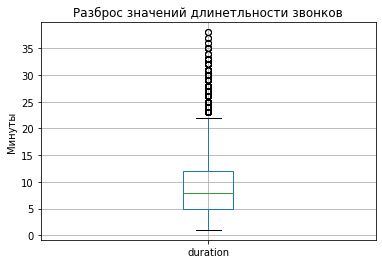

In [18]:
calls.boxplot('duration')
plt.title('Разброс значений длинетльности звонков')
plt.ylabel('Минуты')
plt.show()

> Большинство звонков находится в диапазоне от 5 до 12 минут с медианой в 8 минут. Звонки превышающие 23 минуты считаются выбросами, но мы не будем их удалять так, как они нормальны и нужны для анализа.

#### Таблица `messages` (информация о сообщениях):

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

In [19]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [20]:
messages.duplicated().sum()

0

Нет пропусков и дубликатов, замени тип данных столбца message_date.

In [21]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [22]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


#### Таблица `internet` (информация об интернет-сессиях):

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

In [23]:
internet.info()
internet.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


0

Снова нет пропусков и дубликатов, и опять неподходящий тип данных.

In [24]:
internet['session_date'] = pd.to_datetime(internet['session_date'])

In [25]:
internet.mb_used = np.ceil(internet.mb_used).astype(int)

In [26]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.622098,1252.099842
std,43127.054745,278.387019,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,139.000000,1130.000000
50%,74697.500000,349.000000,1251.000000
75%,112046.250000,560.000000,1380.000000
max,149395.000000,1725.000000,1499.000000


Странных значений нет, можно переходить к следующему датасету.

#### Таблица `tariffs` (информация о тарифах):

- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [27]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Простой датасет без пропусков и дубликатов, содержащей информацию о двух тарифах.

### Добавляем данные

Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножить на значение из тарифного плана; прибавить абонентскую плату, соответствующую тарифному плану).


#### Количество звонков и их продолжительность

In [28]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul","Aug", "Sep", "Oct", "Nov", "Dec"] 
calls['month'] = calls['call_date'].dt.strftime('%b')

In [29]:
calls_count = calls.pivot_table(index='user_id', columns='month', values='id', aggfunc='count')
calls_count.columns = ['calls_count_'+month for month in months]
calls_count.reset_index()

,user_id,calls_count_Jan,calls_count_Feb,calls_count_Mar,calls_count_Apr,calls_count_May,calls_count_Jun,calls_count_Jul,calls_count_Aug,calls_count_Sep,calls_count_Oct,calls_count_Nov,calls_count_Dec
0,1000,NaN,42.0,38.0,NaN,NaN,41.0,28.0,NaN,17.0,37.0,44.0,46.0
1,1001,NaN,NaN,47.0,NaN,NaN,NaN,NaN,NaN,NaN,45.0,NaN,NaN
2,1002,NaN,37.0,27.0,NaN,NaN,21.0,14.0,NaN,NaN,25.0,24.0,25.0
3,1003,NaN,43.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,95.0,97.0,105.0
4,1004,NaN,18.0,15.0,NaN,NaN,20.0,25.0,NaN,7.0,15.0,21.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,1495,NaN,13.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN,112.0,126.0,95.0
488,1496,52.0,62.0,65.0,65.0,6.0,63.0,57.0,67.0,50.0,66.0,56.0,58.0
489,1497,NaN,NaN,58.0,NaN,NaN,NaN,NaN,NaN,NaN,48.0,50.0,NaN
490,1498,NaN,43.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,30.0,53.0


In [30]:
calls_duration_sum = calls.pivot_table(index='user_id', columns='month', values='duration', aggfunc='sum')
calls_duration_sum.columns = ['calls_duration_sum_'+month for month in months]
calls_duration_sum.reset_index()

,user_id,calls_duration_sum_Jan,calls_duration_sum_Feb,calls_duration_sum_Mar,calls_duration_sum_Apr,calls_duration_sum_May,calls_duration_sum_Jun,calls_duration_sum_Jul,calls_duration_sum_Aug,calls_duration_sum_Sep,calls_duration_sum_Oct,calls_duration_sum_Nov,calls_duration_sum_Dec
0,1000,NaN,408.0,333.0,NaN,NaN,340.0,172.0,NaN,159.0,338.0,350.0,466.0
1,1001,NaN,NaN,414.0,NaN,NaN,NaN,NaN,NaN,NaN,430.0,NaN,NaN
2,1002,NaN,289.0,236.0,NaN,NaN,214.0,117.0,NaN,NaN,243.0,212.0,206.0
3,1003,NaN,380.0,802.0,NaN,NaN,NaN,NaN,NaN,NaN,824.0,855.0,961.0
4,1004,NaN,137.0,130.0,NaN,NaN,135.0,171.0,NaN,35.0,117.0,145.0,117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,1495,NaN,92.0,1031.0,NaN,NaN,NaN,NaN,NaN,NaN,954.0,1030.0,813.0
488,1496,521.0,527.0,518.0,594.0,48.0,582.0,555.0,557.0,484.0,662.0,450.0,486.0
489,1497,NaN,NaN,545.0,NaN,NaN,NaN,NaN,NaN,NaN,371.0,490.0,NaN
490,1498,NaN,400.0,NaN,NaN,NaN,175.0,NaN,NaN,NaN,NaN,247.0,471.0


#### Количество отправленных сообщений

In [31]:
messages['month'] = messages['message_date'].dt.month

In [32]:
messages_count = messages.pivot_table(index='user_id', columns='month', values='id', aggfunc='count')
messages_count.columns = ['messages_count_'+month for month in months]
messages_count.reset_index()

,user_id,messages_count_Jan,messages_count_Feb,messages_count_Mar,messages_count_Apr,messages_count_May,messages_count_Jun,messages_count_Jul,messages_count_Aug,messages_count_Sep,messages_count_Oct,messages_count_Nov,messages_count_Dec
0,1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1,1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0
2,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0
3,1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0
4,1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,82.0,82.0,79.0,84.0
422,1496,9.0,45.0,46.0,49.0,40.0,35.0,42.0,41.0,29.0,35.0,46.0,51.0
423,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,14.0,17.0
424,1498,NaN,NaN,NaN,NaN,NaN,NaN,20.0,62.0,44.0,42.0,NaN,NaN


#### Объем израсходованного интернет-трафика

In [33]:
internet['month'] = internet['session_date'].dt.month

In [34]:
internet_sum = internet.pivot_table(index='user_id', columns='month', values='mb_used', aggfunc='sum')
internet_sum.columns = ['internet_sum_'+month for month in months]
internet_sum.reset_index()

,user_id,internet_sum_Jan,internet_sum_Feb,internet_sum_Mar,internet_sum_Apr,internet_sum_May,internet_sum_Jun,internet_sum_Jul,internet_sum_Aug,internet_sum_Sep,internet_sum_Oct,internet_sum_Nov,internet_sum_Dec
0,1000,NaN,NaN,NaN,NaN,2256.0,23257.0,14016.0,14070.0,14581.0,14717.0,14768.0,9827.0
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18452.0,14053.0
2,1002,NaN,NaN,NaN,NaN,NaN,10871.0,17601.0,20347.0,16712.0,13905.0,18610.0,18137.0
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8571.0,12479.0,14779.0,11368.0,10132.0
4,1004,NaN,NaN,NaN,NaN,13415.0,17619.0,22243.0,28607.0,15125.0,18494.0,15631.0,18038.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2616.0,33105.0,29393.0,38972.0,23450.0
493,1496,3766.0,28523.0,24990.0,21098.0,23740.0,20163.0,24395.0,23560.0,26970.0,28215.0,25092.0,20757.0
494,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11512.0,14174.0,19940.0
495,1498,NaN,NaN,NaN,NaN,NaN,NaN,7486.0,24270.0,22166.0,20604.0,NaN,NaN


#### Помесячная выручка с каждого пользователя

In [76]:
gain = internet_sum.merge(calls_duration_sum, on='user_id', how='outer')
gain = gain.merge(messages_count, on='user_id', how='outer')
gain = gain.merge(users[['user_id', 'tariff']], on='user_id', how='outer')

In [77]:
limit = { # включено [message, internet, minute]
    'smart': [50, 15360, 500],
    'ultra': [1000, 30720, 3000]
}

prices = { # стоимость дополнительной услуги [message, internet, minute]
    'smart': [3, (200/1024), 3],
    'ultra': [1, (150/1024), 1]
}
 
fee = { # стоимость тарифа
    'smart': 550,
    'ultra': 3000
}

In [78]:
def montly_revenue(row):
    
    """
    Функция принимает на вход ряд из набора данных gain и возвращает выручку
    для конкретного пользователя в конкретный месяц
    """
    
    user_tariff = row['tariff']
    minutes = row['calls_duration_sum_'+month]
    megabytes = row['internet_sum_'+month]
    messages = row['messages_count_'+month]
    gain = 0
    
    minutes_minus_limit_price = (minutes - limit[user_tariff][2])*prices[user_tariff][2]
    if minutes_minus_limit_price < 0:
        minutes_minus_limit_price = 0
        
    megabytes_minus_limit_price = (megabytes - limit[user_tariff][1])*prices[user_tariff][1]
    if megabytes_minus_limit_price < 0:
        megabytes_minus_limit_price = 0
        
    messages_minus_limit_price = (messages - limit[user_tariff][0])*prices[user_tariff][0]
    if messages_minus_limit_price < 0:
        messages_minus_limit_price = 0
        
    return minutes_minus_limit_price + megabytes_minus_limit_price + messages_minus_limit_price + fee[user_tariff]

In [79]:
for month in months:
    gain['revenue_'+month] = 0
for month in months:
    gain['revenue_'+month] = gain.apply(montly_revenue, axis=1)

<a id='section3'></a>

## Анализ данных

___

#### Распределение пользования пакетом интернета

In [39]:
users_mb = users.merge(internet_sum, on='user_id', how='outer')
ultra_mb = users_mb[users_mb.tariff == 'ultra']
smart_mb = users_mb[users_mb.tariff == 'smart']

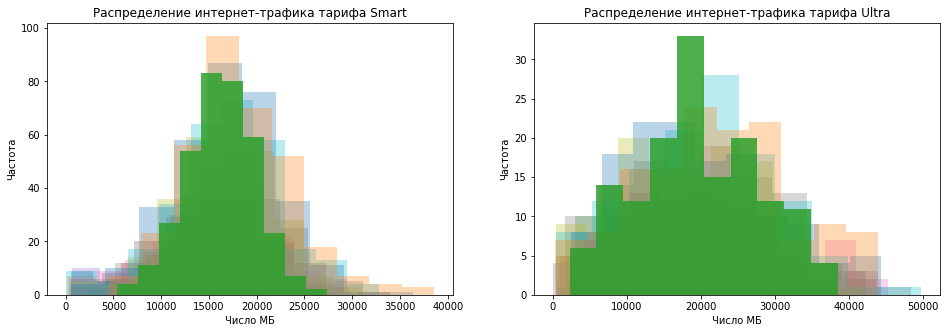

Среднее SMART: 16211.21349113584
Дисперсия SMART: 12828074.80480589
Стандартное отклонение SMART: 3581.6301881693325

Среднее ULTRA: 19744.8859179747
Дисперсия ULTRA: 66883936.373713896
Стандартное отклонение ULTRA: 8178.259984477988


In [40]:
ultra_mb['mean_value'] = ultra_mb.loc[:, 'internet_sum_Jan':'internet_sum_Dec'].apply(lambda row: np.mean(row), axis=1)
smart_mb['mean_value'] = smart_mb.loc[:, 'internet_sum_Jan':'internet_sum_Dec'].apply(lambda row: np.mean(row), axis=1)

plt.figure(figsize=(16,5))
plt.subplot2grid((1,2),(0,0))
for month in months:
    smart_mb['internet_sum_'+month].plot(kind='hist', alpha=0.3)
plt.hist(smart_mb['mean_value'], alpha = 0.85)
plt.xlabel('Число МБ')
plt.ylabel('Частота')
plt.title('Распределение интернет-трафика тарифа Smart')

plt.subplot2grid((1,2),(0,1))
for month in months:
    ultra_mb['internet_sum_'+month].plot(kind='hist', alpha=0.3)
plt.hist(ultra_mb['mean_value'], alpha = 0.85)
plt.xlabel('Число МБ')
plt.ylabel('Частота')
plt.title('Распределение интернет-трафика тарифа Ultra')
plt.show()

print('Среднее SMART:', smart_mb.mean_value.mean())
print('Дисперсия SMART:', smart_mb.mean_value.var())
print('Стандартное отклонение SMART:', smart_mb.mean_value.std())

print()

print('Среднее ULTRA:', ultra_mb.mean_value.mean())
print('Дисперсия ULTRA:', ultra_mb.mean_value.var())
print('Стандартное отклонение ULTRA:', ultra_mb.mean_value.std())


#### Распределение пользования пакетом минут

In [41]:
users_calls = users.merge(calls_duration_sum, on='user_id', how='outer')
ultra_calls = users_calls[users_calls.tariff == 'ultra']
smart_calls = users_calls[users_calls.tariff == 'smart']

In [42]:
ultra_calls['mean_value'] = ultra_calls.loc[:, 'calls_duration_sum_Jan':'calls_duration_sum_Dec'].apply(lambda row: np.mean(row), axis=1)
smart_calls['mean_value'] = smart_calls.loc[:, 'calls_duration_sum_Jan':'calls_duration_sum_Dec'].apply(lambda row: np.mean(row), axis=1)

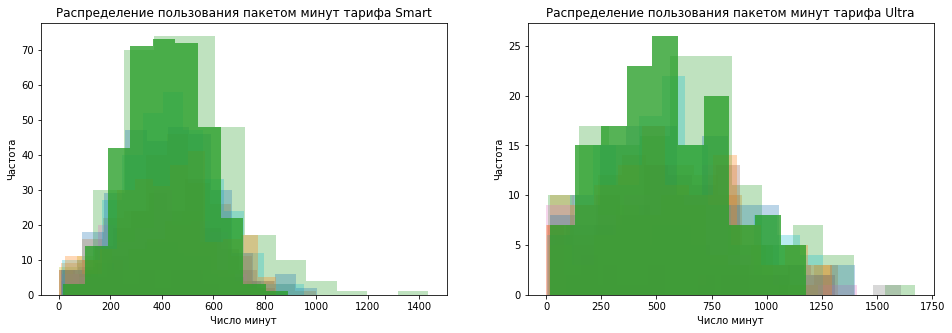

Среднее SMART: 420.8480194908566
Дисперсия SMART: 20578.276241342694
Стандартное отклонение SMART: 143.4513026826271

Среднее ULTRA: 546.9984013461287
Дисперсия ULTRA: 71872.06712691842
Стандартное отклонение ULTRA: 268.0896624767886


In [43]:
plt.figure(figsize=(16,5))
plt.subplot2grid((1,2),(0,0))
for month in months:
    smart_calls['calls_duration_sum_'+month].plot(kind='hist', alpha=0.3, bins=12)
smart_calls['mean_value'].plot(kind='hist', alpha=0.8)
plt.xlabel('Число минут')
plt.ylabel('Частота')
plt.title('Распределение пользования пакетом минут тарифа Smart')

plt.subplot2grid((1,2),(0,1))
for month in months:
    ultra_calls['calls_duration_sum_'+month].plot(kind='hist', alpha=0.3, bins=12)
ultra_calls['mean_value'].plot(kind='hist', alpha=0.8)
plt.xlabel('Число минут')
plt.ylabel('Частота')
plt.title('Распределение пользования пакетом минут тарифа Ultra')
plt.show()

print('Среднее SMART:', smart_calls.mean_value.mean())
print('Дисперсия SMART:', smart_calls.mean_value.var())
print('Стандартное отклонение SMART:', smart_calls.mean_value.std())

print()

print('Среднее ULTRA:', ultra_calls.mean_value.mean())
print('Дисперсия ULTRA:', ultra_calls.mean_value.var())
print('Стандартное отклонение ULTRA:', ultra_calls.mean_value.std())

#### Распределение пользования пакетом сообщений

In [44]:
users_messages = users.merge(messages_count, on='user_id', how='outer')
ultra_messages = users_messages[users_messages.tariff == 'ultra']
smart_messages = users_messages[users_messages.tariff == 'smart']

In [45]:
ultra_messages['mean_value'] = ultra_messages.loc[:, 'messages_count_Jan': 'messages_count_Dec'].apply(lambda row: np.mean(row), axis=1)
smart_messages['mean_value'] = smart_messages.loc[:, 'messages_count_Jan': 'messages_count_Dec'].apply(lambda row: np.mean(row), axis=1)

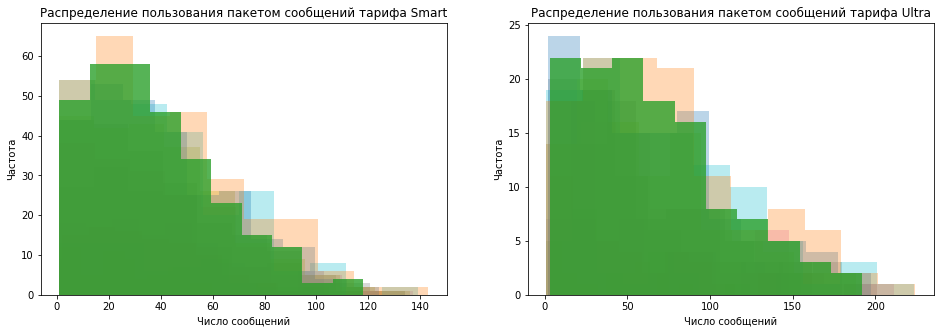

Среднее SMART: 37.57560563057252
Дисперсия SMART: 617.5094965861844
Стандартное отклонение SMART: 24.849738360517687

Среднее ULTRA: 64.55580197132616
Дисперсия ULTRA: 1882.7452175564713
Стандартное отклонение ULTRA: 43.390612090133864


In [46]:
plt.figure(figsize=(16,5))
plt.subplot2grid((1,2),(0,0))
for month in months:
    smart_messages['messages_count_'+month].plot(kind='hist', alpha=0.3)
smart_messages.mean_value.plot(kind='hist', alpha=0.8)
plt.xlabel('Число сообщений')
plt.ylabel('Частота')
plt.title('Распределение пользования пакетом сообщений тарифа Smart')

plt.subplot2grid((1,2),(0,1))
for month in months:
    ultra_messages['messages_count_'+month].plot(kind='hist', alpha=0.3)
ultra_messages.mean_value.plot(kind='hist', alpha=0.8)
plt.xlabel('Число сообщений')
plt.ylabel('Частота')
plt.title('Распределение пользования пакетом сообщений тарифа Ultra')
plt.show()

print('Среднее SMART:', smart_messages.mean_value.mean())
print('Дисперсия SMART:', smart_messages.mean_value.var())
print('Стандартное отклонение SMART:', smart_messages.mean_value.std())

print()

print('Среднее ULTRA:', ultra_messages.mean_value.mean())
print('Дисперсия ULTRA:', ultra_messages.mean_value.var())
print('Стандартное отклонение ULTRA:', ultra_messages.mean_value.std())

> - Для пользователей тарифа смарт количетсво предоставляемых сообщений и минут оказались избыточными: люди в среднем расходуют 64 (+-43) сообщений из 1000 допустимых. И 550 +-270 минут из доступных 3000.
- Большинству пользователей тарифа SMART не хватает интерент-трафика, так как они в среднем расходуют 16 МБ и больше. Это почти не отличается от пользователей тарифа ULTRA, которые в месяц тратят в среднем всего на 3 МБ больше.
- Пользователи тарифа SMART гораздо чаще превышают лимит доступных услуг и, возможно, приносят компании больше выручки, чем люди, выбирающие более дорогой тариф. Данную гипотезу можно проверить.

<a id='section4'></a>

## Проверка гипотез

Подготовим данные: составим два датасета с выручкой от двух разных тарифов.

In [50]:
ultra_gain = gain[gain.tariff == 'ultra']
smart_gain = gain[gain.tariff == 'smart']
ultra_gain['av_revenue'] = ultra_gain.loc[:, 'revenue_Jan':'revenue_Dec'].apply(lambda row: np.mean(row), axis=1)
smart_gain['av_revenue'] = smart_gain.loc[:, 'revenue_Jan':'revenue_Dec'].apply(lambda row: np.mean(row), axis=1)

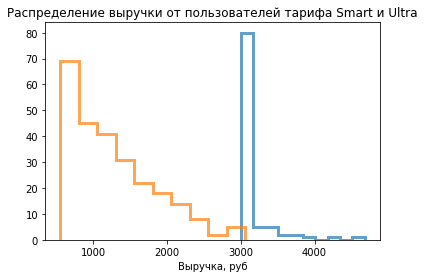

Средняя плата абонентов Smart: 1254.763424430536
Средняя плата абонентов Ultra: 3112.403350515464


In [95]:
plt.hist(ultra_gain.av_revenue, histtype='step', lw=3, alpha=0.7)
plt.hist(smart_gain.av_revenue, histtype='step', lw=3, alpha=0.7)
plt.title('Распределение выручки от пользователей тарифа Smart и Ultra')
plt.xlabel('Выручка, руб')
plt.show()

print("Средняя плата абонентов Smart:", smart_gain.av_revenue.mean())
print("Средняя плата абонентов Ultra:", ultra_gain.av_revenue.mean())

Плата пользователей тарифа Smart очень редко превышает 3000 рублей, на гистограмме видно, что распредление их абоненстких плат практически не пересекается. Так как это выборки, проверим гипотезу об их возможном отличии в генеральной совокупности.

##### Гипотеза:
Абоненская плата пользователей тарифа Smart `отличается` от платы пользователей Ultra.

Таким образом, нулевая гипотеза H0 соответсвует утверждению о том, что стоимость их услуг равна, а альтернативная H1 - не равна. Проверка гипотезы - проверка средних генеральной совокупности.

In [85]:
alpha = 0.05

results = st.ttest_ind(smart_gain.av_revenue.dropna(), ultra_gain.av_revenue.dropna(), equal_var=False)

print('Значение p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвегнуть нулевую гипотезу')

Значение p-value: 1.2676779000367562e-129
Отвергаем нулевую гипотезу


 > Следовательно, наша гипотеза о том, что выручка отличается подтвердиалсь. Используя тариф Smart абонент трати гораздо меньше, чем абонент Ultra.

##### Гипотеза 2
Выручка пользоваетлей Москвы отличается от выручки жителей других городов.
- H0 - выручка не отличается 
- H1 - выручка отличается

In [80]:
gain = gain.merge(users[['city', 'user_id']], on='user_id', how='outer')
gain_moscow = gain[gain.city == 'Moscow']
gain_other = gain[gain.city != 'Moscow']

In [82]:
gain['av_revenue'] = gain.loc[:, 'revenue_Jan':'revenue_Dec'].apply(lambda row: np.mean(row), axis=1)

In [93]:
aplha = .05

results = st.ttest_ind(gain_moscow.av_revenue.dropna(), gain_other.av_revenue.dropna(), equal_var=False)

print('Значение p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвегнуть нулевую гипотезу')

Значение p-value: 0.13936403445559842
Не получилось отвегнуть нулевую гипотезу


> Получается, москвичи тратят на связь в среднем столько же, сколько и жители остальной России.

## Заключение

В проекте я рассмотрела пользователей двух тарифов Smart и Ultra. По гистограммам распределения можно сделать вывод, что на свзяь (звонки, сообщения и интернет) они тратят значительно отличающуюся плату: 1250 Smart и 3100 за Ultra и при этом используют сопоставимое количество услуг. Исходя из анализа, `тариф Smart гораздо выгоднее`, так как предлагает расширить пакет за дополнительную невысокую плату, тогда как тариф Ultra предлагает пакет услуг, которые пользователи зачастую не используют даже наполовину.

Было проверено две гипотезы, которые подтвердили утверждения:
- 1. Средняя выручка пользователей тарифов Smart Ultra отличается
- 2. Поведение пользователей разных городов России в целом схоже: их траты на связь практически не отличаются.